In [37]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

## 1、预测时间序列

### 1.1 数据准备

此函数根据请求（通过batch_size参数）创建任意数量的时间序列，每个序列的长度为n_steps，并且每个序列中每个时间步长只有一个值（即所有序列都是单变量的）。该函数返回一个形状为[批处理大小，时间步长，1]的NumPy数组，其中每个序列是两个固定振幅但频率和相位随机的正弦波的总和，再加上一点噪声。

In [22]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)


X_train包含7000个时间序列（即其形状为[7000，50，1]），而X_valid包含2000个（从第7000个时间序列到8999个），X_test包含1000个（从9000个时间序列到9999个）。由于我们要为每个序列预测一个值，因此目标是列向量（例如，y_train的形状为[7000，1]）。

In [23]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

### 1.2 基准指标

我们使用一个全连接网络来作为基准，其mse loss大约为0.004。

In [30]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0525 - val_loss: 0.0251
Epoch 2/20
219/219 [==============================] - 0s 880us/step - loss: 0.0184 - val_loss: 0.0141
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0102
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0092 - val_loss: 0.0087
Epoch 5/20
219/219 [==============================] - 0s 801us/step - loss: 0.0079 - val_loss: 0.0076
Epoch 6/20
219/219 [==============================] - 0s 855us/step - loss: 0.0071 - val_loss: 0.0067
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 8/20
219/219 [==============================] - 0s 707us/step - loss: 0.0059 - val_loss: 0.0056
Epoch 9/20
219/219 [==============================] - 0s 914us/step - loss: 0.0055 - val_loss: 0.0053
Epoch 10/20
219/219 [==============================] - 0s 946us/step - loss: 0.0052 - val_

### 1.3 简单的RNN

我们看一下一个简单的RNN的效果：

In [32]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 12ms/step - loss: 0.9197 - val_loss: 0.8354
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.6965 - val_loss: 0.5940
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.4767 - val_loss: 0.4386
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.4125 - val_loss: 0.3828
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.3558 - val_loss: 0.3292
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.3062 - val_loss: 0.2848
Epoch 7/20
219/219 [==============================] - 2s 8ms/step - loss: 0.2690 - val_loss: 0.2505
Epoch 8/20
219/219 [==============================] - 2s 9ms/step - loss: 0.2342 - val_loss: 0.2199
Epoch 9/20
219/219 [==============================] - 2s 10ms/step - loss: 0.2007 - val_loss: 0.1846
Epoch 10/20
219/219 [==============================] - 2s 9ms/step - loss: 0.1687 - val_loss: 0.

可以看到其MSE loss为0.14，不如全连接网络。

### 1.4 深度RNN
我们再看一下深度RNN的效果：


In [33]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 9s 32ms/step - loss: 0.0628 - val_loss: 0.0118
Epoch 2/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0088 - val_loss: 0.0063
Epoch 3/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0061 - val_loss: 0.0053
Epoch 4/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 5/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 7/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 8/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 9/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0032 - val_lo

深度RNN的mse loss约为0.003，优于全连接网络了。

### 1.5 预测未来几个时间步长

到目前为止，我们仅仅预测了下一个时间步长的值，但是我们可以很容易地通过适当地更改目标来预测未来几步的值（例如，要预测下十步，只需将目标更改为未来10步，而不是未来1步）。但是，如果我们要预测接下来的10个值怎么办？


第一种选择是使用已经训练好的模型，使其预测下一个值，然后将该值加到输入中（就像这个预测值实际上已经有了），然后再次使用该模型预测后面的值，以此类推，如以下代码所示：

In [35]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]
print(Y_pred)

[[[ 0.59878635]
  [ 0.5962956 ]
  [ 0.5101831 ]
  [ 0.3353485 ]
  [ 0.09413009]
  [-0.14639963]
  [-0.32425976]
  [-0.42145067]
  [-0.47292346]
  [-0.4698904 ]]]


如你所料，由于误差可能会累积（如图158所示），因此对下一步长的预测通常会比对未来几个时间步长的预测更为准确。如果你在验证集上评估此方法，会发现MSE约为0.029。这比以前的模型要高得多，但这也是一个更难的任务，因此比较没有太大的意义。把这个性能与单纯预测（仅仅预测这个时间序列在10个时间步长内保持不变）或简单的线性模型进行比较会有更大的意义。单纯方法很糟糕（它的MSE约为0.223），但是线性模型的MSE约为0.0188：这比使用RNN一次预测未来的一步要好得多，而且训练和运行速度也更快。如果你只想预测一些较复杂的任务的未来几个时间步长，这个方法可能会工作得很好。

第二种选择是训练RNN一次预测所有10个值。我们仍然可以使用一个序列到向量的模型，但是它输出10个值而不是1个值。但是，我们首先需要将目标更改为包含接下来10个值的向量：


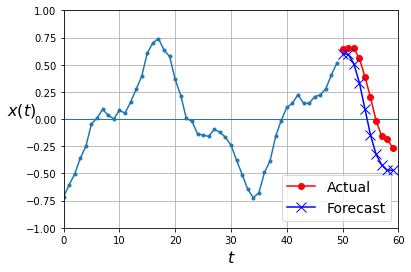

In [39]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

该模型运行良好：接下来10个时间步长的MSE约为0.008。这比线性模型好得多。但是我们仍然可以做得更好：实际上，与其训练模型在最后一个时间步长预测下一个10个值，不如训练模型在每个时间步长来预测下一个10个值。换句话说，我们可以将这个序列到向量的RNN转换为序列到序列的RNN。这种技术的优势在于，损失将包含每个时间步长的RNN输出项，而不仅仅是最后一个时间步长的输出项。这意味着将有更多的误差梯度流过模型，它们不需要随时间而“流淌”。它们从每个时间步长的输出中流出。这会稳定和加速训练。

为了清楚起见，模型在时间步长0时会输出一个向量，其中包含时间步长1到10的预测，然后在时间步长1时模型会预测时间步长2到11，以此类推。因此，每个目标必须是与输入序列长度相同的序列，在每个步长都必须包含10维向量。

In [ ]:
见book。